<a href="https://colab.research.google.com/github/jamiehenzy/Genome_analysis_ML/blob/main/PSET_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **6.8701 | 6.8700[J] | HST.507[J]**



#**Fall 2024 Problem Set 1**

Due: October 3 at 11:59 PM EDT

Create a copy of this notebook and work on your local copy.

Submit .ipynb file as well as PDF to Canvas.

#*Helpful links*
AnnData is the main object used, containing Pandas dataframes for describing observations and variables (.obs and .var), the data itself (.X), and dimensionality reductions (.obsm and .varm).

https://anndata.readthedocs.io/en/latest/



Here is the ScanPy tutorial for clustering, which may be helpful for (1).

https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html


https://pydeseq2.readthedocs.io/en/latest/ will be used for some of the differential expression in problem 2.

Using https://muon-tutorials.readthedocs.io/en/latest/single-cell-rna-atac/pbmc10k/2-Chromatin-Accessibility-Processing.html may help for the snATAC-seq portion, mostly for QC...

In [ ]:
%pip install numpy anndata scanpy[skmisc] igraph leidenalg umap-learn muon plotnine harmonypy pydeseq2 pymemesuite pyjaspar upsetplot gprofiler-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 MB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.8/188.8 kB 15.1 MB/s eta 0

In [ ]:
import os, gc
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from matplotlib.pyplot import rc_context
import anndata
import scanpy as sc
from muon import atac as ac
from plotnine import (
    ggplot,
    aes,
    scale_x_log10,
    scale_y_log10,
    geom_point,
    geom_violin,
    geom_boxplot,
    geom_jitter,
    theme_matplotlib,
    theme_set,
)
from gprofiler import GProfiler
from pyjaspar import jaspardb
import Bio
from typing import List

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

from scipy.sparse import diags

MOTIF_LIST = jaspardb(release="JASPAR2024").fetch_motifs(collection="CORE", tax_group=["vertebrates"], species=9606)

theme_set(theme_matplotlib())
sc.set_figure_params(dpi_save=600, dpi=150, frameon=False)
sc.settings.verbosity=2
sc.settings.figdir="."

# **1. Single-Cell Cell Type Inference**

## Understanding Cell Types and RNA-Seq

A cell type is defined by distinctive characteristics such as structure, function, and gene expression, influenced by both genetic and environmental factors. Each type plays a specific role within an organism—for example, neurons in the nervous system or cardiomyocytes in the heart. Traditionally, cell types were identified through microscopic observation, focusing on physical and structural characteristics. Today, with advances in molecular biology, we can also classify cells based on their gene expression profiles using techniques like RNA sequencing (RNA-seq).

### Role of RNA-Seq in Cell Classification
RNA-seq is a powerful tool that quantifies gene expression across individual cells, providing insights into cellular functions and identities. This method allows researchers to infer cell types by analyzing gene expression patterns. While your current project uses pre-collected RNA-seq data, understanding the data collection process is beneficial. In the wet-lab, RNA-seq involves extracting RNA, converting it into cDNA, and sequencing it to analyze gene expression.

### Biological Rationale
From a biological perspective, the link between phenotype and gene expression is well-established. Phenotypic traits of a cell, such as its appearance and function, are primarily determined by the genes it expresses, moderated by its environment. Thus, RNA-seq data can serve as a robust basis for inferring cell types in research settings, including studies on complex diseases like Alzheimer’s, by understanding the functional implications of gene expression.  

### RNA-seq & Alzheimer's Research

Alzheimer's disease affects certain types of brain cells more severely than others, such as specific neuron subtypes. RNA-seq can help identify these vulnerable cell types by showing which cells express Alzheimer’s-related genes more than others, or reveal upregulation or downregulation of genes that may contribute to Alzheimer’s pathology, such as those involved in amyloid-beta production or tau protein phosphorylation.

# **1. Single-cell RNA-seq cell type annotation**

In this task, you will explore primary data analysis related to single-nucleus RNA sequencing (snRNA-seq) from postmortem human cortex samples of Alzheimer's disease patients. The initial dataset is stored in an H5AD object, a format designed for efficient storage of sparse matrices commonly found in single-cell RNA-seq experiments. The initial H5AD object was processed using [this script](https://gist.github.com/benjamin-james/b4ebd6c5182f45f290d21a89091e3043).

As discussed in lecture, a common method for visualizing RNA-seq expression profiles is to apply dimensionality reduction techniques such as t-SNE, PCA, or UMAP. These methods help cluster cells with similar expression profiles, aiding in the identification of distinct cell types. Preliminary PCA and UMAP embeddings are provided, and throughout the problem, your task will be to refine and obtain more accurate cell annotations.

In [ ]:
def download_dataset():
  """
  Download and load the single-cell RNA sequencing dataset as an AnnData object.

    The dataset is retrieved from a specified URL and loaded into an AnnData object,
    which is designed to store annotated data matrices in the context of single-cell
    genomics. The AnnData format facilitates handling large datasets typical in
    high-throughput biology with efficient data manipulation and analysis capabilities.

    Returns:
    --------
    adata : AnnData
        An AnnData object containing the downloaded single-cell RNA-seq data. Key components include:

        - .X : A data matrix (cells × genes) of gene expression values, typically counts or normalized counts.
        - .obs : DataFrame with one row per cell and columns for various cell-level annotations.
        - .var : DataFrame with one row per gene and columns for various gene-level annotations.
        - .uns : Unstructured dictionary-like attribute for miscellaneous data related to the dataset.
        - .obsm : Dictionary-like structure for storing arrays that annotate observations (cells).
        - .varm : Dictionary-like structure for storing arrays that annotate variables (genes).
        - .obsp : Pairwise annotation of observations as a sparse matrix.
        - .varp : Pairwise annotation of variables as a sparse matrix.
  """
  !wget -c https://compbio.mit.edu/benjames/MFC_RNA.h5ad -O MFC_RNA.h5ad
  adata = anndata.read_h5ad("MFC_RNA.h5ad", backed="r")
  return adata

adata = download_dataset()

--2024-09-17 21:45:45--  https://compbio.mit.edu/benjames/MFC_RNA.h5ad
Resolving compbio.mit.edu (compbio.mit.edu)... 128.52.131.233
Connecting to compbio.mit.edu (compbio.mit.edu)|128.52.131.233|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



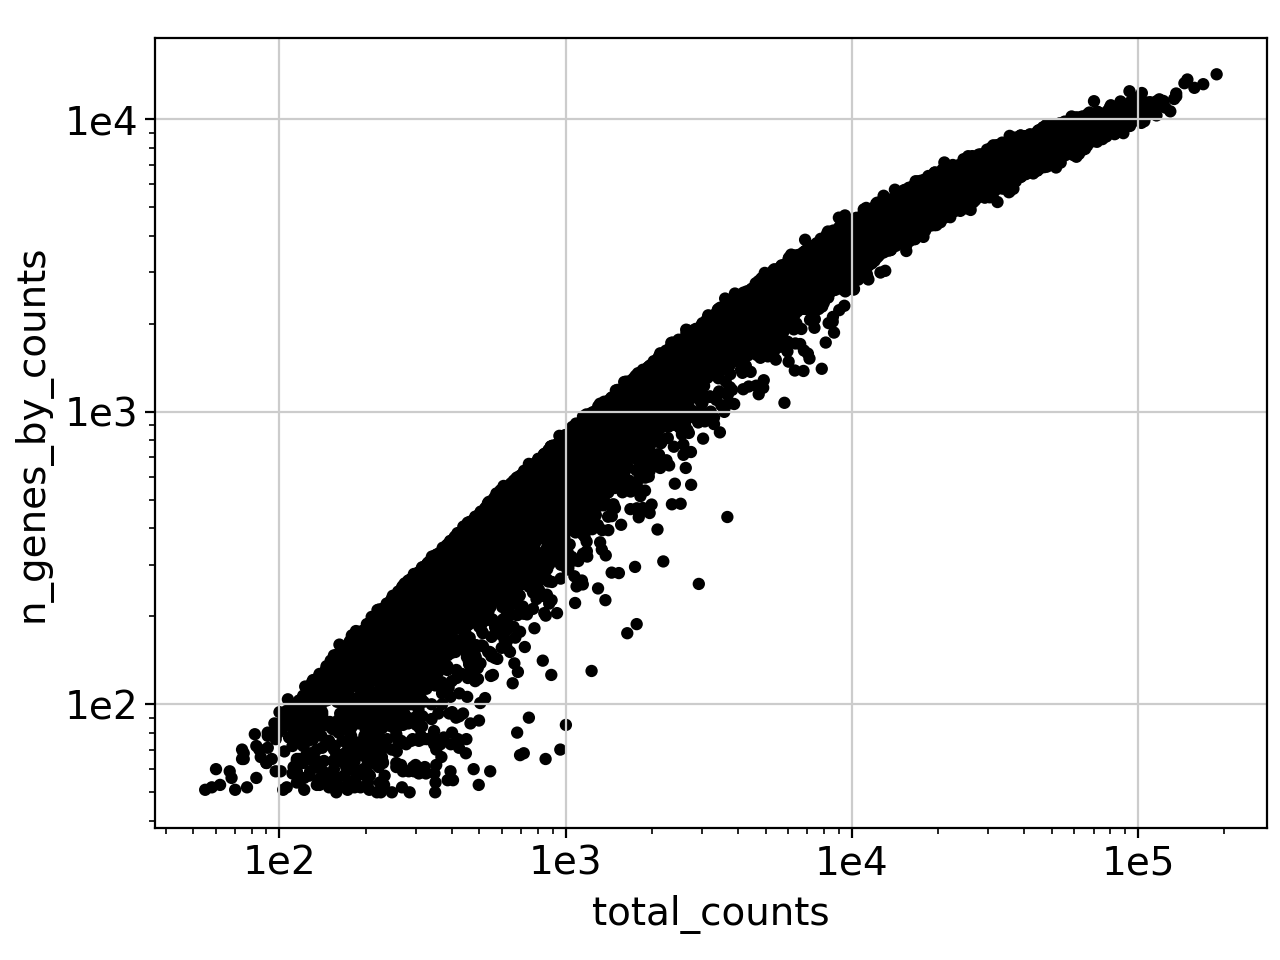

<Figure Size: (640 x 480)>

In [ ]:
ggplot(adata.obs, aes(y="n_genes_by_counts", x="total_counts")) + geom_point() + scale_x_log10() + scale_y_log10()

In the above plot, x-axis represents total RNA molecules detected per cell, and y-axis represents total number of genes detected per cell (how many genes had non-zero counts). This is a plot to just make sure that our quality control is rigorous. Read https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html

Based on that guide, is our quality control plot ok? What do we usually look for?

---

##### Student Explanation Here: **Write your response here and delete this comment**

---


Next, we will do a exercise analyzing the AnnData object to see what the most highly expressed genes are.

In [ ]:
def find_highly_expressed_genes(adata, top_n=10):
    """
    Return the names of the top n most highly expressed genes in an AnnData object.

    Hint: adata.X : A data matrix (cells × genes) of gene expression values, typically counts or normalized counts.
    We want to sum across one dimension, so that we have a vector of [1 x gene] that gives gene counts. Then,
    sort, and return the names of the most counted genes.

    Typically, the names are the HGNC names of the gene.
    """
    pass

top_genes_adata = find_highly_expressed_genes(adata, top_n=100)

Pick one of the top 10 most highly expressed genes from the dataset. Look up the biological function of that gene.

Is it a housekeeping gene? If yes, explain why it is highly expressed across cells. If it is not a housekeeping gene, explain why it might be highly expressed in this particular dataset (e.g., in the context of Alzheimer's disease or the specific cell types being studied).

---

##### Student Explanation Here: **Write your response here and delete this comment**

---

## 1.1 Doublet finding: Data cleaning

## RNA-seq Primer

In single-cell RNA sequencing (scRNA-seq), the goal is to capture the RNA from individual cells. In droplet-based scRNA-seq, individual cells are encapsulated into tiny droplets along with a barcode and reagents that help capture their RNA. Each droplet typically contains one cell, and the barcode ensures that the RNA from each cell is labeled uniquely, allowing researchers to track the gene expression of individual cells.

Sometimes, two cells accidentally get captured in the same droplet. This creates a doublet, meaning that RNA from both cells is merged and tagged as if it came from a single cell. Doublets can confuse the analysis because they appear to express genes from two different cell types.

Tools like [Scrublet](https://www.cell.com/cell-systems/fulltext/S2405-4712(18)30474-5) simulate these by taking random pairs of observed transcriptomes and simulating what doublets look like.

Scrublet has been run for convenience, and you can plot `sc.pl.umap(adata, color="doublet_score")` to see what cells are likely doublets.

### Scrublet In Simple Terms

Scrublet has three steps:

1. Simulating Doublets: Scrublet takes the RNA data from your cells and starts by randomly pairing up actual cells in your dataset. This simulates what it would look like if two cells had accidentally been sequenced together as one (a doublet).

2. Comparing Real Cells to Simulated Doublets: Once it has simulated these doublets, Scrublet compares each real cell to the simulated doublets. If a real cell looks very similar to one of the simulated doublets (in terms of its gene expression), it is flagged as a potential doublet.

3. Scoring: Scrublet assigns a doublet score to each cell. A higher score means it’s more likely the cell is a doublet.

By running Scrublet, you can identify and remove these doublets, ensuring that only high-quality, single-cell data is used for analysis.






In [ ]:
adata

AnnData object with n_obs × n_vars = 182027 × 36601 backed at 'MFC_RNA.h5ad'
    obs: 'library_id', 'subject', 'msex', 'age_death', 'pmi', 'race', 'Pathologic_diagnosis_of_AD', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_chrX', 'log1p_total_counts_chrX', 'pct_counts_chrX', 'total_counts_chrY', 'log1p_total_counts_chrY', 'pct_counts_chrY', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'gene_length', 'strand', 'interval', 'chrX', 'chrY', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'neighbors', 'pca', 'scrublet', 'umap', 'predicted_doublet_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In the AnnData object, the "doublet_score" has already been precomputed. The two lines of code will plot UMAPs: one where darker green indicates a higher probability of being a doublet, and one where orange highlights predicted doublets.

Do doublets cluster together in the UMAP plot?
Why might this be the case (or not be the case)?

---

##### Student Explanation Here: **Write your response here and delete this comment**

---

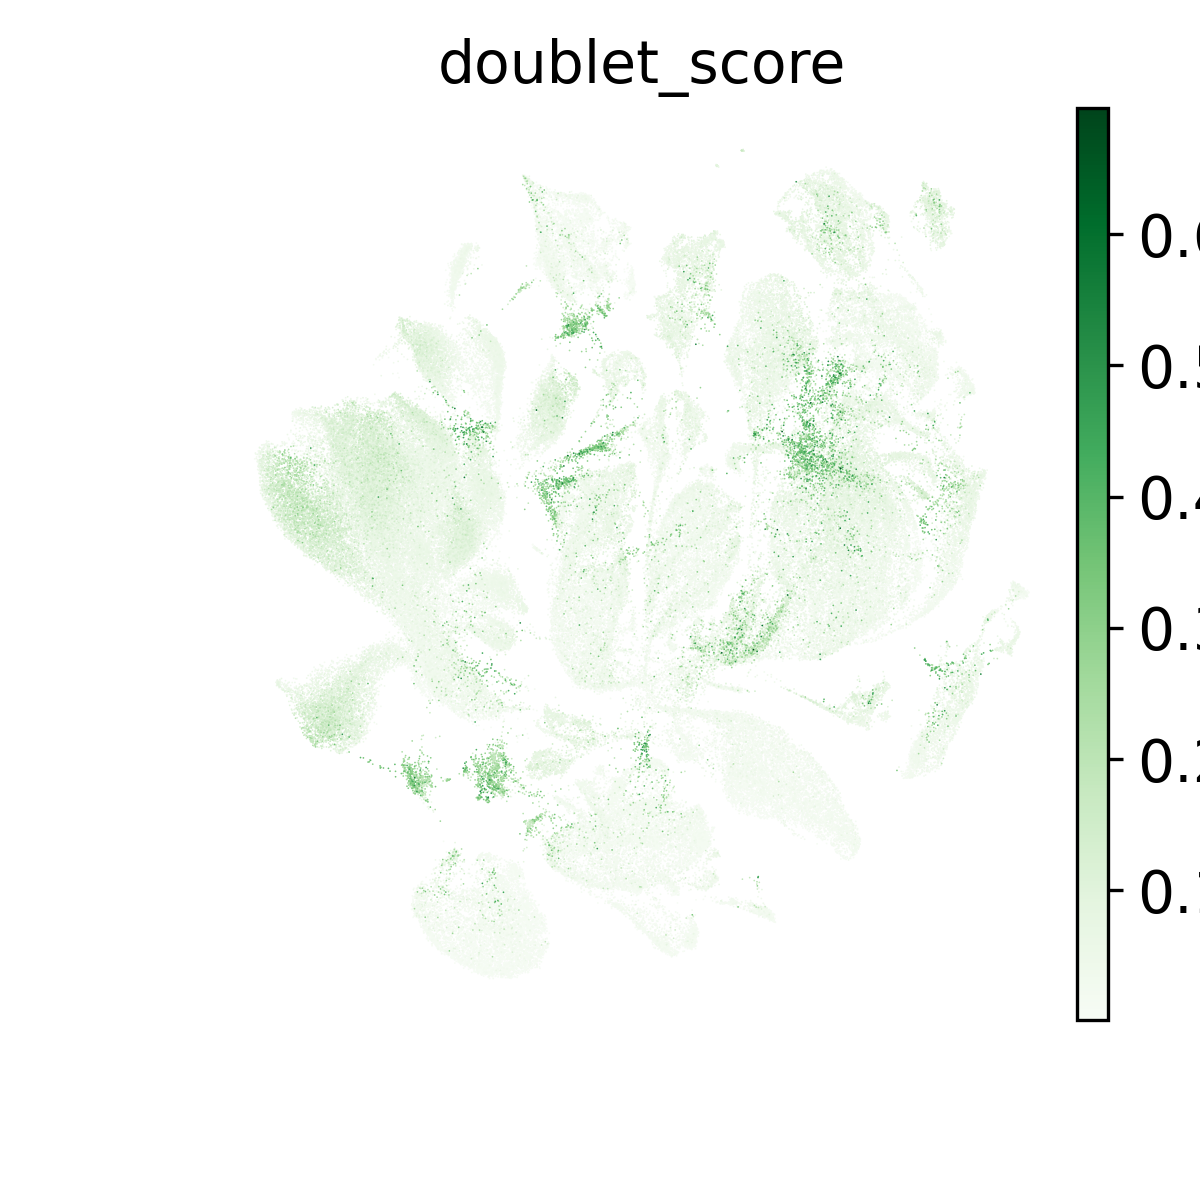

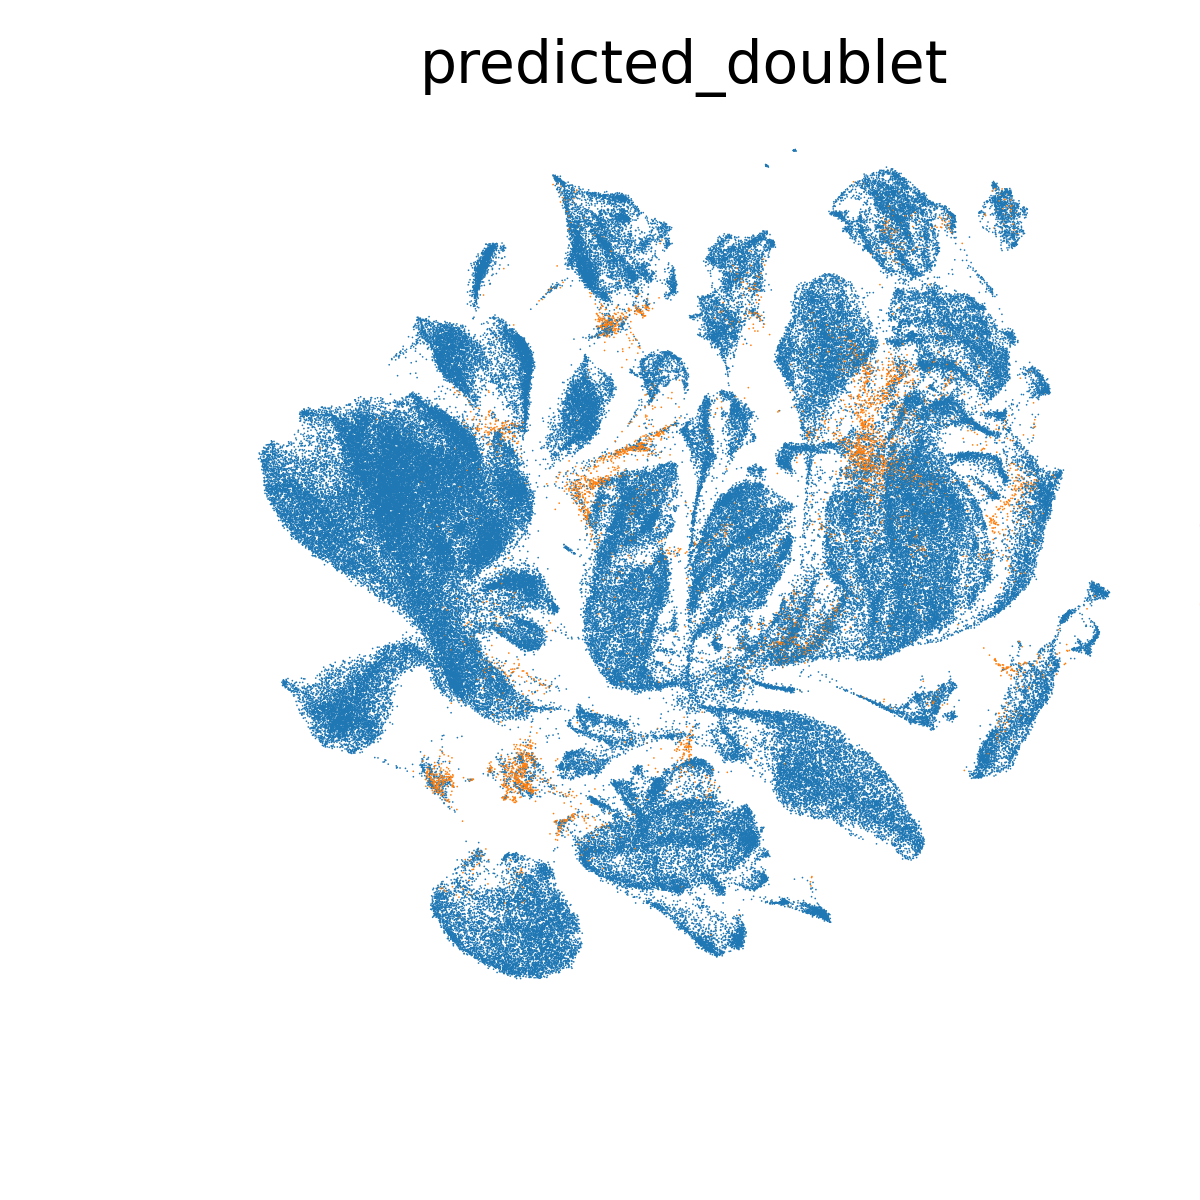

In [ ]:
sc.pl.umap(adata, color="doublet_score", color_map="Greens")
sc.pl.umap(adata, color="predicted_doublet")

Complete the simulate_doublets function by implementing the logic to simulate doublets from the existing data. Once the function is complete, run refine_doublet_scores, which will work correctly if your implementation of simulate_doublets is correct. After running the function, inspect the resulting plot that compares the original and refined doublet scores. Your implementation is correct if it is similar to the original doublet plot.

In [ ]:
def simulate_doublets(adata: anndata.AnnData, sim_doublet_ratio: float = 2.0) -> anndata.AnnData:
  """
  Simulate doublets by randomly sampling pairs of cells from the given AnnData object
  and adding their gene expression counts together.

  Parameters:
  -----------
  adata : AnnData
      The input AnnData object containing the single-cell RNA-seq data. This contains the
      cell-by-gene matrix (.X), along with gene and cell metadata (.var and .obs).

  sim_doublet_ratio : float, optional (default=2.0)
      The ratio of simulated doublets to the number of real cells in the dataset. For
      example, a ratio of 2.0 means twice as many doublets as real cells will be simulated.

  Returns:
  --------
  doublet_adata : AnnData
      A new AnnData object containing the simulated doublets. Key components include:

      - .X: A matrix where each row represents a simulated doublet, created by summing the
            gene expression counts of two randomly selected cells.
      - .var: Gene metadata inherited from the input AnnData object.
      - .obsm: Contains a matrix named "doublet_parents" that stores the indices of the two
               parent cells for each simulated doublet. The shape is a 2D matrix of size (num_cells, 2).
      - .uns: Stores additional parameters, such as the "sim_doublet_ratio" used in the simulation.
  """
  if adata.isbacked: ### If using on-disk format, load into memory now.
    adata = adata.to_memory()

  doublet_parents = ## Has a two column numpy matrix with the integer indices of the parents

  X = ### Create a new X matrix

  return anndata.AnnData(X, var=adata.var, obsm={"doublet_parents": doublet_parents}, uns={"parameters": {"sim_doublet_ratio": sim_doublet_ratio}})

In [ ]:
def refine_doublet_scores(adata: anndata.AnnData, top_genes: int = 1000):
    """
    Refine doublet scores for each sample in an AnnData object by simulating doublets
    and running Scrublet on highly variable genes. The results will update the doublet
    scores and predicted doublets in the original AnnData object.

    Parameters:
    -----------
    adata : anndata.AnnData
        The input AnnData object containing single-cell RNA-seq data, which includes
        cell metadata such as library IDs and initial doublet scores.

    top_genes : int, optional (default=10000)
        The number of highly variable genes to consider for Scrublet doublet detection.
        Default is 10,000.

    Returns:
    --------
    None
        The function updates the AnnData object `adata` in-place by refining the
        "doublet_score" and "predicted_doublet" columns in `adata.obs` for each sample.

    Notes:
    ------
    - This function assumes that doublet scores have already been computed and stored
      in `adata.obs["doublet_score"]` and `adata.obs["predicted_doublet"]`.
    - The function also assumes that the data includes a `library_id` field in `adata.obs`
      to distinguish different samples (experiments).
    - The Scrublet results are compared against the original doublet scores, and a scatter
      plot is produced to visualize this comparison.
    """

    # Backup original doublet scores and predicted doublets
    adata.obs["base_doublet_score"] = adata.obs["doublet_score"]
    adata.obs["base_predicted_doublet"] = adata.obs["predicted_doublet"]

    # Loop over each unique sample in the dataset
    for sample in tqdm(pd.unique(adata.obs["library_id"])):
        # Filter the dataset for the current sample and load into memory if necessary
        full_data = adata[adata.obs["library_id"] == sample, :].to_memory()

        # Identify highly variable genes
        sc.pp.highly_variable_genes(full_data, flavor='seurat_v3', n_top_genes=top_genes, subset=True)

        # Simulate doublets for the current sample
        sim_data = simulate_doublets(full_data)

        # Run Scrublet using the real and simulated doublets
        sc.pp.scrublet(full_data, adata_sim=sim_data)

        # Update doublet scores and predicted doublets in the main dataset
        adata.obs.loc[full_data.obs_names, "doublet_score"] = full_data.obs["doublet_score"]
        adata.obs.loc[full_data.obs_names, "predicted_doublet"] = full_data.obs["predicted_doublet"]

        # Free up memory
        del full_data

    # Plot comparison of new and original doublet scores
    ggplot(adata.obs, aes(x="doublet_score", y="base_doublet_score")) + geom_point()

The filter_anndata_by_qc function needs to be run with appropriate cutoff parameters to clean the AnnData object for further analysis after the batch correction (section 1.2).

Decide on reasonable cutoff values for the following QC metrics:

`max_pct_counts_mt`: The maximum percentage of mitochondrial RNA.

`min_total_counts`: The minimum number of gene-mapped reads per cell.

`min_n_genes`: The minimum number of genes detected per cell.

Then, run the function using these cutoff values to obtain a cleaned AnnData object for the next step.

In [ ]:
def filter_anndata_by_qc(adata, max_pct_counts_mt, min_total_counts, min_n_genes) -> anndata.AnnData:
    """
    Filter the AnnData object based on quality control (QC) metrics to remove low-quality cells.

    Parameters:
    -----------
    adata : anndata.AnnData
        The input AnnData object containing single-cell RNA-seq data, including QC metrics such as
        percent mitochondrial RNA, total counts, and number of genes detected.

    max_pct_counts_mt : float, optional (default=100.0)
        The maximum percentage of mitochondrial RNA allowed for a cell to be kept. A high percentage
        of mitochondrial reads can indicate low-quality cells, as these cells might be dying or damaged.

    min_total_counts : int, optional (default=0)
        The minimum number of total gene-mapped reads required for a cell to be kept. Cells with low
        total counts may have insufficient sequencing depth, leading to poor identification of cell types.

    min_n_genes : int, optional (default=0)
        The minimum number of detected genes per cell. Cells with low numbers of detected genes may
        also indicate poor quality or insufficient sequencing depth.

    Returns:
    --------
    filtered_adata : anndata.AnnData
        A filtered AnnData object with low-quality cells removed based on the specified thresholds.
        The filtered data is saved to a new file and reloaded in backed mode for further analysis.

    Notes:
    ------
    - The function filters out predicted doublets (cells suspected of being doublets) as well.
    - A high percentage of mitochondrial reads may indicate low-quality or dying cells.
    - A low number of total counts or genes per cell may suggest low sequencing depth, resulting
      in inaccurate cell type identification.
    - After filtering, the cleaned data is saved to an H5AD file with gzip compression and reloaded.
    """
    adata = adata[~adata.obs["predicted_doublet"] & (adata.obs["pct_counts_mt"] <= max_pct_counts_mt) &
                  (adata.obs["total_counts"] >= min_total_counts) &
                  (adata.obs["n_genes_by_counts"] >= min_n_genes), :]

    adata.write_h5ad("MFC_RNA_QC.h5ad", compression="gzip")

    return anndata.read_h5ad("MFC_RNA_QC.h5ad", backed="r")

# Decide on parameters then run the function below so that we have an updated adata in memory
# adata = filter_anndata_by_qc(...)

## 1.2 Batch correction

Batch correction is a technique used to correct for unwanted technical variation that arises when experiments are processed in separate batches. In single-cell RNA sequencing (scRNA-seq) and other biological experiments, samples are often processed in different conditions, machines, or times, leading to differences (biases) in the data that are not due to biological factors.

Batch effects can make it appear as though cells from different batches are different from each other, even when they are biologically similar. This can distort the results of analyses like clustering or gene expression comparisons, leading to incorrect conclusions.

Batch correction aims to remove these technical differences while preserving the true biological variability between cells. It helps to align cells from different batches so that cells with similar biological characteristics cluster together, regardless of which batch they came from.

For example, in scRNA-seq, cells from different patient samples or different experimental days might have batch-specific biases. Batch correction ensures that cells are clustered by their true biological properties rather than technical artifacts.

#### Why Use K-Means and Harmony for Batch Correction?

[Harmony](https://www.nature.com/articles/s41592-019-0619-0) is one of the most cited and [best performing](https://www.nature.com/articles/s41592-021-01336-8/figures/2) for this task, employing a K Means based clustering across datasets and updating across iterations. Implement k-means with k-means++ initialization in the `kmeans` function, using the best k-means++ initialization over 10 different random seedings, as in scikit-learn's KMeans implementation.

In [ ]:
def kmeans_plus_plus(X: np.ndarray, k: int) -> np.ndarray:
    """
    Initialize cluster centroids using the k-means++ algorithm.

    Parameters:
    -----------
    X : np.ndarray
        The data matrix of shape (n_samples, n_features) where each row represents a data point.

    k : int
        The number of clusters (centroids) to initialize.

    Returns:
    --------
    centroids : np.ndarray
        An array of shape (k, n_features) representing the initial cluster centroids
        chosen by the k-means++ algorithm.
    """
    return None

def assign_clusters(X: np.ndarray, centroids: np.ndarray) -> np.ndarray:
    """
    Assign each data point in X to the nearest centroid.

    Parameters:
    -----------
    X : np.ndarray
        The data matrix of shape (n_samples, n_features).

    centroids : np.ndarray
        The matrix of shape (k, n_features) containing the centroids.

    Returns:
    --------
    labels : np.ndarray
        A 1D array of shape (n_samples,) where each element represents the index of the nearest centroid for a data point.
    """
    pass

def compute_centroids(X: np.ndarray, labels: np.ndarray, k: int) -> np.ndarray:
    """
    Recompute centroids by averaging the points assigned to each cluster.

    Parameters:
    -----------
    X : np.ndarray
        The data matrix of shape (n_samples, n_features).

    labels : np.ndarray
        A 1D array of shape (n_samples,) containing the cluster label for each data point.

    k : int
        The number of clusters.

    Returns:
    --------
    centroids : np.ndarray
        A matrix of shape (k, n_features) representing the new centroids after re-calculating the mean of points in each cluster.
    """
    pass

def kmeans(data: np.ndarray, num_clusters: int, n_init: int = 10) -> np.ndarray:
    """
    Run the K-Means algorithm to find cluster centroids.

    Parameters:
    -----------
    data : np.ndarray
        The data matrix of shape (n_samples, n_features).

    num_clusters : int
        The number of clusters (k) to create.

    n_init : int, optional (default=10)
        The number of times to run the K-Means algorithm with different centroid seeds. The best clustering is selected.

    Returns:
    --------
    centroids : np.ndarray
        A matrix of shape (num_clusters, n_features) representing the final centroids of the clusters.
    """
    for i in range(n_init):
        I = np.random.choice(np.arange(data.shape[0]), num_clusters)
        clust = data[I, :]
        ### Add iterative logic for updating clusters
    return centroids

# This line will use the K-Means function during the batch correction process using Harmony.
sc.external.pp.harmony_integrate(adata, key="library_id", cluster_fn=kmeans)

If you did the above K-Means and Harmony code correctly, you should have `adata.obsm["X_pca_harmony"]` in memory, which you need for 1.3.

You can check with `sc.pl.embedding(adata, basis="X_pca_harmony", color="library_id")` and compare with the PCA embedding `sc.pl.pca(adata, color="library_id")`

## 1.3 Cell Type Annotation
Graph clustering is generally used to obtain cell types. From the clustering obtained, rename each of the cell types into the column `CellType` with the following gene markers:



    SYT1, SLC17A7: Excitatory neuron ("Exc")
    SYT1, GAD1, GAD2: Inhibitory neuron ("Inh")
    AIF1, P2RY12, CSF1R: Microglia ("Mic")
    MBP, MOBP, PLP1: Oligodendrocyte ("Oli")
    PDGFRA, VCAN: Oligodendrocyte precursor cell ("Opc")
    GFAP, AQP4, S100B: Astrocyte ("Ast")
    FLT1, CLDN5, PDGFRB, DLC1, CEMIP: Vascular cell ("Vas")


In [ ]:
def cluster_data(adata:anndata.AnnData) -> anndata.AnnData:
    """Cluster the data and compute a UMAP embedding"""
    sc.pp.neighbors(adata, use_rep="X_pca_harmony") ### Use Harmony for KNN graph
    sc.tl.leiden(adata)
    sc.tl.umap(adata)
    adata.write_h5ad("RNA_Harmony.h5ad", compression="gzip")
    adata = anndata.read_h5ad("RNA_Harmony.h5ad", backed="r")
    return adata

adata = cluster_data(adata)

In [ ]:
def plot_qc(adata:anndata.AnnData, groupby:str="leiden"):
  """For some clustering, plot distributions of %MT and % doublet score.
   Percent mitochondrial if dominating a cluster's signature can indicate poor sequencing quality.
   Additionally, if a cluster has a strong enrichment of doublet like cells, it may be an un-called doublet.
   """
  with rc_context({"figure.figsize": (10, 5)}):
    sc.pl.violin(adata, groupby=groupby keys=["pct_counts_mt"], rotation=90)
    sc.pl.violin(adata, groupby=groupby, keys=["doublet_score"], rotation=90)

plot_qc(adata)

In [ ]:
### What are the gene expression profiles?
def plot_markers(adata:anndata.AnnData,
                 groupby="leiden",
                 markers:List[str]=["SYT1", "SLC17A7", "GAD1", "GAD2", "MBP", "MOBP", "PLP1", "VCAN", "PDGFRA", "AQP4", "GFAP", "S100B", "CSF1R", "C3", "AIF1", "FLT1", "CLDN5", "PDGFRB", "DLC1", "CEMIP"]) -> anndata.AnnData:
    """Load in a tiny object containing only the genes of interest, but normalize to the full data size, and plot a dotplot."""
    pdata = adata[:, markers].to_memory()
    pdata.X = np.log1p(diags(10000. / pdata.obs["total_counts"].values).dot(pdata.X))
    sc.pl.dotplot(pdata, groupby=groupby, var_names=["SYT1", "SLC17A7", "GAD1", "GAD2", "MBP", "MOBP", "PLP1", "VCAN", "PDGFRA", "AQP4", "GFAP", "S100B", "CSF1R", "C3", "AIF1", "FLT1", "CLDN5", "PDGFRB", "DLC1", "CEMIP"])
    return pdata

plot_markers(adata, groupby="leiden")

In [ ]:
def assign_celltypes(adata:anndata.AnnData, **celltype_table) -> anndata.AnnData:
  """Takes a input dict of cell type names to a list of strings, assigns clusters in that list to the key.
  Based on markers in the previous ipynb cell, assign cell types to each cluster."""
  adata.obs["CellType"] = "Unassigned"
  for ct, leiden in celltype_table.items():
    adata.obs.loc[adata.obs["leiden"].isin(leiden), "CellType"] = ct
  return adata

adata = assign_celltype(adata,
  Exc=["0", "1"], ### Add for all your cell types...
  Inh=["4", "5"], ### similarly for Oli, Opc, Ast, Mic, Vas
)
plot_markers(adata, groupby="CellType")
adata.write_h5ad("RNA_Annotated.h5ad", compression='gzip')

In [ ]:
### Save and reload only annotated cells if you want, but not really necessary.
if False: ### re-plot UMAP if you want pretty plots
  adata = adata[adata.obs["CellType"] != "Unknown", :]
  adata.write_h5ad("RNA_Annotated.h5ad", compression='gzip')
  adata = anndata.read_h5ad("RNA_Annotated.h5ad", backed="r")
  sc.pp.neighbors(adata, use_rep="X_pca_harmony")
  sc.tl.umap(adata)

After completing the code blocks above, you should have `plot_markers(adata, gropuby="CellType")`, showing that cell types express markers with high accuracy. This will generate plots for you to analyze in 1.4. Additionally, you should write to `RNA_Annotated.h5ad` as a completed object for question 2.

## 1.4 Biological Interpetation of Cell Types

From your experience annotating the clusters, answer the following questions:

1. How does sample heterogeneity impact annotations? Do you attribute these effects to technical or biological effects more?
---

##### Student Explanation Here: **Write your response here and delete this comment**

---

2. Does Alzheimer's disease significantly change what cells are called here, in terms of cells missing? What could be leading to sample level heterogeneity?

---

##### Student Explanation Here: **Write your response here and delete this comment**

---

3. What can you say about the number of distinct clusters and number of cells corresponding to neurons (Exc, Inh) versus glia (Oli, Opc, Ast, Mic) versus vasculature (Vas)?

---

##### Student Explanation Here: **Write your response here and delete this comment**

---

4. For annotating sub-types if given markers (such as PVALB and SST for two types of inhibitory neurons), would you subset the cells and re-run any of PCA/Harmony/Leiden, or keep any of these the same? Why?

---

##### Student Explanation Here: **Write your response here and delete this comment**

---

# **2. Differential Expression Analysis**

### Bulk RNA-seq, Psuedobulk, and scRNA-seq

Pseudo-bulk RNA sequencing is a technique used in the analysis of single-cell RNA sequencing (scRNA-seq) data, offering a bridge between single-cell resolution and traditional bulk RNA-seq methods.

#### Bulk RNA-seq
Bulk RNA sequencing aggregates RNA from a collection of cells, typically millions, into a single sample for sequencing. This provides a general overview of gene expression across all cells in the sample but lacks the resolution to discern differences among individual cell types or states within the sample. It's highly effective for analyzing overall gene expression in tissues or cultures where the average expression level is the main focus.

 Single-cell RNA-seq (scRNA-seq)
In contrast, single-cell RNA sequencing involves isolating and sequencing the RNA from individual cells. This method provides a high-resolution view of gene expression variations across individual cells within a heterogeneous population. It's particularly useful for understanding complex tissues with multiple cell types, identifying novel cell types, or studying cellular responses at an individual level.

##### Why Pseudo-Bulk?
While scRNA-seq offers high granularity, certain analyses like differential gene expression can lead to erroneous results since cells from the same sample are very well correlated, much more than to other smaples, which may lead to inflated p-values. Pseudo-bulk analysis mitigates this by aggregating single-cell data from the same cell type or condition into "pseudo-samples." This aggregation:

- Increases statistical power: By summing counts across cells, it ensures the statisitics are well calibrated, avoiding inflated Type 1 error from a more naive approach.
- Maintains cell-type specificity: By aggregating only cells of the same type or from the same condition, it retains crucial biological distinctions that are averaged out in traditional bulk RNA-seq.
- Many well-developed statistical tools for differential expression in bulk RNA-seq can then be applied to these pseudo-bulk datasets, leveraging their robustness and maturity.

Thus, pseudo-bulk analysis provides a practical compromise, harnessing the cell-specific insights of scRNA-seq while utilizing the robust statistical frameworks developed for bulk RNA-seq.

### Psuedobulk and Alzheimer's

To understand cell type-specific changes, it is important to identify differentially expressed genes (DEGs) between conditions (e.g., Alzheimer's status). Pseudobulk methods are great for many of these when metadata is rich and the sample size is large, as they are well suited for subject-level covariate adjustments; additionally, the runtime of fancier models like GLMM will take much longer to compute and can suffer more from misspecification.

In this section, you will create a pseudo-bulk dataset and explore how factors such as covariates and normalization methods impact the analysis of differentially expressed genes.

### 2.1: Creation and Analysis of Pseudo-Bulk scRNA-seq Data

1. Filter the AnnData object to retain only microglia cells. You can do this by subsetting the data using a cell type annotation column (e.g., `adata.obs['CellType'] == 'Mic')`.
2. For each sample (using the `library_id` in adata.obs), sum the raw counts (not the normalized counts) across all microglia cells to create a new pseudo-bulk AnnData object. This means aggregating the adata.X matrix for all cells within each sample. The resulting pseudo-bulk AnnData object should have one row per sample, where the values (`.X`)represent the total integer counts per gene across all microglia cells from that sample.

3. Calculate the library size for each sample in the pseudo-bulk object (i.e., the total number of counts per sample), and create a boxplot showing the distribution of library sizes, grouped by Alzheimer's disease status (e.g., using `adata.obs['Pathologic_diagnosis_of_AD']` to distinguish between AD and control samples).



In [ ]:
def pseudobulk(adata: anndata.AnnData, groupby: str) -> anndata.AnnData:
    """
    Aggregate raw counts from single-cell data to create a pseudo-bulk AnnData object.

    Parameters:
    -----------
    adata : anndata.AnnData
        The input single-cell RNA-seq data.

    groupby : str
        Column in `adata.obs` used for grouping cells to aggregate.

    Returns:
    --------
    pseudobulk_adata : anndata.AnnData
        A new AnnData object with rows as groups and columns as genes, with summed gene expression counts per group.

    Notes:
    ------
    - Ensure raw counts from `adata.X` are used.
    - Handle large datasets by loading data in batches if necessary.
    """
    pass

ps_mic = pseudobulk(adata[adata.obs["CellType"] == "Mic", :].to_memory(), groupby="library_id")
sc.pp.calculate_qc_metrics(ps_mic, inplace=True)

To check if you succesfully impleneteded this, your `ps_mic` object should have a `ps_mic` object with 19 rows and 36601 columns, with columns in `obs` that are invariant to `library_id`, like `Sex` and Alzheimer's status.

## 2.2: PCA Visualization of Pseudo-Bulk scRNA-seq Data

Principal Component Analysis (PCA) is a dimensionality reduction technique used to reduce the complexity of high-dimensional data while retaining most of the variation in the data. This is particularly useful in genomics where each sample may contain expressions for thousands of genes. PCA simplifies the data into principal components (PCs) that capture the most variance, making it easier to visualize and interpret the underlying patterns in the data.

For single-cell RNA-seq data, especially when aggregated into pseudo-bulk data, log-normalization is crucial before PCA because gene expression data are come from a Poisson like process and need to be somewhat normalized in order for PCA to work. See [this paper](https://www.nature.com/articles/s41592-023-01814-1) for a comparison of different transformations, but log normalized counts performs very well.


In [ ]:
def perform_pca_analysis(adata: anndata.AnnData, log_normalize: bool = True) -> None:
    """
    Perform PCA on pseudo-bulk RNA-seq data and plot the first two principal components.

    Parameters:
    -----------
    adata : anndata.AnnData
        The pseudo-bulk AnnData object containing summed raw counts of gene expression.
        Each row in `adata` should represent a pseudo-bulked sample.
        This is supposed to take in ps_mic from earlier.

    log_normalize : bool, optional (default=True)
        Flag to determine whether to log-normalize the data before PCA. Log-normalization
        helps stabilize variance across genes which may enhance PCA performance.

    Returns:
    ------
    1. Check if log normalization is requested and apply it to the data.
       - Use sc.pp.normalize_total(adata, target_sum=10000) and sc.pp.log1p(adata) if `log_normalize` is True.
    2. Perform PCA on the (possibly log-normalized) data using `sc.pp.pca()`.
    3. Create a scatter plot of the first two principal components from the PCA.
       - Use `sc.pl.pca()` to plot, coloring the points by Alzheimer's diagnosis.

    Notes:
    ------
    - Ensure the Alzheimer's diagnosis is included in `adata.obs` to color the PCA plot.
    - This function updates the AnnData object in place if log normalization is performed.
    """
    counts = adata.X.copy()
    # Implement the log-normalization if requested
    if log_normalize:

        # Your code here: Normalize the data, but take a copy!!!
        pass

    # Perform PCA analysis by sc.pp.pca()
    # Your code here: Run PCA and store the results

    # Visualization: Plotting the first two principal components
    # Your code here: Generate PCA scatter plot colored by Alzheimer's diagnosis

    adata.X = counts
    del adata.uns["log1p"] ### indicator for log transform
    pass

## 2.3: Differential Gene Expression Analysis in Microglia: T-Test and Visualization Techniques

Understanding how gene expression differs between cells from Alzheimer's disease (AD) patients and control subjects is crucial for identifying potential biological mechanisms underlying the disease. This section focuses on comparing gene expression in microglia between these two groups using statistical and visual analytical methods.

1. [T-Test](https://en.wikipedia.org/wiki/Student%27s_t-test) for Differential Expression: The student's t-test is a general method used to determine if there are significant differences between the means of two groups. In the context of single-cell RNA-seq, it helps identify genes that are differentially expressed between conditions (e.g., AD vs. control).

2. [MA Plot](https://en.wikipedia.org/wiki/MA_plot): a type of scatter plot that visualizes differences between measurements taken in two conditions. It represents the intensity ratio (M) versus the average intensity (A) across the conditions, helping to spot trends and outliers in differential expression data. In our analysis, the MA plot will show log2 fold changes (y-axis) versus average expression levels (x-axis) for genes, highlighting the magnitude and direction of changes in gene expression between AD and control microglia.


3. [Volcano Plot](https://en.wikipedia.org/wiki/Volcano_plot_(statistics)): to display statistical significance versus magnitude of change. It is commonly used in genomic studies to show differential expression between two biological states. The plot will display -log10 of the p-value (y-axis) against the log2 fold change (x-axis), allowing us to quickly identify genes with significant changes in expression due to their large fold changes and low p-values, which are potentially relevant for further biological investigation.

In [ ]:
def run_ttest(adata:anndata.AnnData, groupby="Pathologic_diagnosis_of_AD") -> pd.DataFrame:
  """Make sure you log normalize the AnnData object (preferably a copy to not destroy the adata object's integer counts),
  and then run sc.tl.rank_genes_groups using a t-test. See documentation for this function
  at https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.rank_genes_groups.html
  Make sure you also add the log1p total counts per gene as well (un normalized)"""
  tdata = adata.copy()
  sc.tl.rank_genes_groups(tdata)### MODIFY HERE
  df = sc.get.rank_genes_groups_df(tdata)
  ### Add number of total transcripts for each gene as well (integer)
  return df

def volcano(df:pd.DataFrame, gene_col="gene", log2FC_col="log2FC", padj_col="p_adjust"):
  """Plot a volcano plot of a dataframe, taking in custom column names. This is to ensure
  that this function works for both t-test as well as pyDESeq2 in 2.4.
  You can use plotting libraries like plotnine (ggplot, etc), matplotlib, or seaborn for this."""
  pass

def maplot(df:pd.DataFrame, gene_col="gene", log2FC_col="log2FC", library_size_col="log1p_total_counts"):
  """Plot an MA plot of a dataframe, taking in custom column names. This is to ensure
  that this function works for both t-test as well as pyDESeq2 in 2.4.
  You can use plotting libraries like plotnine (ggplot, etc), matplotlib, or seaborn for this."""
  pass

# After you write functions, run them below and make sure your outputs are correct. The
# t_test_frame function takes in the ps_mic object from earlier.
# t_test_frame = run_ttest(ps_mic, ...)
# volcano(t_test_frame, ...)
# maplot(t_test_frame, ...)

After you implement and run the functions, you should get MA and Volcano plots of the t-test.

## 2.4 Controlling for Covariates

When applying DESeq2 to analyze pseudo-bulked excitatory neurons from individuals with and without Alzheimer’s disease, considering covariates such as sex, age at death, post-mortem interval (PMI) is crucial. These factors can introduce variability in gene expression that is not directly related to disease status. For example, age at death might influence gene expression patterns independently of Alzheimer's pathology, and similarly, sex can influence the expression of X and Y chromosomal genes.

Running the analysis without these covariates can provide a baseline understanding of the differences in gene expression between the groups.
However, not including relevant covariates may be considered [omitted variable bias](https://en.wikipedia.org/wiki/Omitted-variable_bias), which can misattribute changes to this un-included covariates. Therefore, including these covariates helps to refine this analysis by accounting for these additional sources of variation, thereby isolating the effect of the disease condition more precisely. This allows us to draw a stronger link between gene expression and disease status.

Run PyDESeq2 on the pseudo-bulked excitatory neurons in two different configurations:
 - No covariates
 - Sex, age_death, PMI as covariates

Plot each of the volcano plots.

In [ ]:
def run_deseq2(adata, groupby:str, covariates:List[str]=[], n_cpus:int=4):
    """From the pseudo-bulk AnnData object, run DESeq2 on a categorical group with optional covariates.
    A step by step tutorial is provided at https://pydeseq2.readthedocs.io/en/latest/auto_examples/plot_step_by_step.html#sphx-glr-auto-examples-plot-step-by-step-py"""
    inference = DefaultInference(n_cpus=n_cpus)
    dds = DeseqDataSet(adata=adata.copy(),
                       design_factors=## Fill in
                       inference=inference)
    dds.deseq2()
    result = DeseqStats(dds, contrast=["condition", "B", "A"], inference=inference) ### Fill in with correct parameters
    return result.summary()

1. After writing the code and running the plots, do you think the plot that controls for covariates, or the plot that does not control for covariates, is more useful? Why or why not?

---

##### Student Explanation Here: **Write your response here and delete this comment**

---

2. How do these plots differ from the t-test volcano plot in 2.3? That is, what is a biological conclusion that can be drawn from one plot but not the other?

---

##### Student Explanation Here: **Write your response here and delete this comment**

---

3. Can you find one example of a gene that became more significant after controlling for covaritates (sex, age_death, PMI), and one example of a gene that became less significant after controlling for covariates? Come up with a testable, mechanistic, biological hypothesis for why this might be, for both genes.

---

##### Student Explanation Here: **Write your response here and delete this comment**

---

## 2.5

From these analyses, we want to observe what are the most dyregulated cell types as well as what genes may be overlapping between them. For example, some cell types like glial cell types like astrocytes and microglia share many functions, and excitatory neurons and inhibitory neurons can share similar functions. Venn diagrams do not work very well for larger number of categories, so many people use [UpSet plot](https://en.wikipedia.org/wiki/UpSet_plot) to summarize these changes.

For each of the 7 major cell types from (1), run PyDESeq2 with the full covariate list, and plot an UpSet plot (from `upsetplot`) comparing the genes with adjusted p-values below 0.05 for every cell type.

In [ ]:
deg_out = {}
for ct in ["Exc", "Inh", "Oli", "Opc", "Ast", "Mic", "Vas"]:
  ps = pseudobulk(adata[adata.obs["CellType"] == ct, :].to_memory(), groupby="library_id")
  deg_out[ct] = run_pydeseq2(ps, groupby="", covariates=[]) ### update with correct columns

# **3 Secondary analysis of snRNA-seq**

[Gene ontology](https://en.wikipedia.org/wiki/Gene_Ontology) (GO) analysis is a method used to interpret the functional implications of large-scale genomic or transcriptomic data, such as those obtained from single-nucleus RNA sequencing (snRNA-seq). GO provides a framework to label genes with standardized terms, or ontologies, that describe their associated biological processes, cellular components, and molecular functions. This labeling allows researchers to identify not just individual genes, but groups of genes that share common functions or roles within the cell.

When differentially expressed genes (DEGs) are identified between different conditions or cell types, GO analysis can help determine if specific functions or processes are statistically overrepresented among these genes compared to what would be expected by chance in the genome. This enrichment analysis helps to hypothesize mechanisms potentially driving changes observed in the dataset, such as those involved in a disease state or developmental process. In studies of neurodegenerative diseases like Alzheimer's, GO analysis might reveal an enrichment of genes involved in pathways like synaptic signaling or immune response, highlighting these processes as areas of interest for potential therapeutic interventions.

## 3.1 GO Enrichment Analysis
Take differential expression results from DESeq2 and obtain functional enrichments with gprofiler2. Summarize the top upregulated and downregulated (log2FC > 0 and log2FC < 0) results per cell type, using FDR threshold of 0.05

In [ ]:
def run_go(df, log2FC_col:str="log2FC", padj_col:str="p_adjust", min_log2FC:float=0., max_padj:float=0.05) -> pd.DataFrame:
    """For significant genes, add upregulated genes (log2FC > min_log2FC) and downregulated genes (log2FC < -min_log2FC)
    to query, and send to gprofiler2.
    """
    gp = GProfiler(return_dataframe=True)
    query = {}
    query["Up"] = [] ### List of genes
    query["Down"] = []
    return gp.profile(query=query, combined=True)

def run_all_go(tbl) -> pd.DataFrame:
  """Run GO for all cell types, using deg_out from part 2 as input. Modify arguments to run_go as needed"""
  out = {}
  for ct, df in tbl.items():
    out[ct] = run_go(df) ### Add your params here
  return pd.concat(out).reset_index(drop=True)

Desired output should be a dataframe of pathways, and show the top 5 up and down pathways (if any!) per cell type.

## 3.2 Gene set scores

We know that genes do not act in isolation, so combining genes can be a powerful way to try to increase power. What we can then do is compute a disease score that adds the contributions of dyregulated genes by adding the genes that increase expression in Alzheimer's disease and subtracting those that decrease expression in Alzheimer's disease. This then computes a cell-level score of how diseased a cell is.

For microglia, add the DEG gene set score for the upregulated gene set as well as the downregulated gene set using `sc.tl.score_genes` for both, and subtract the resulting scores. `sc.tl.score_genes` computes a background gene set to make sure gene level counts aren't influenced by counts.

Then, show the score distribution for each sample, grouping by AD diagnosis.


In [ ]:
def load_microglia(path:str="RNA_Annotated.h5ad") -> anndata.AnnData:
  """You should log-normalize the data and return it"""
  mic = anndata.read_h5ad("RNA_Annotated.h5ad", backed="r")
  mic = mic[mic.obs["CellType"] == "Mic", :].to_memory()
  ### TODO: log-normalize
  return mic

def add_deg_score(adata:anndata.AnnData, up_genes:List[str], down_genes:List[str], key_added:str="deg_score"):
  """Add a DEG score by subtracting the score_genes for up DEGs and the score_genes for down DEGs, on log normalized data"""
  sc.tl.score_genes(adata, key_added="up")
  sc.tl.score_genes(adata, key_added="down")
  adata.obs[key_added] = adata.obs["up"] - adata.obs["down"]

In [ ]:
def plot_score_distribution(obs:pd.DataFrame, sample_col:str="library_id", pathology_col:str="Pathologic_diagnosis_of_AD",
                            score_column:str="scores"):
    """Summarize the scores by a boxplot or violin plot, summarizing per sample, and coloring the boxplot or violin plot by AD status.
    Plotnine/seaborn may be more feature rich than sc.pl.violin or sc.pl.boxplot, but you can probably get them to work.
    Use adata.obs for the first argument."""
    ### Plot here

What can you infer from the score distribution across samples? Does the distribution of cells shift between AD and non-AD?

## 3.3

We want to see how well this score generalizes. If the score is more indicative of one data set, it may overfit and really only capture that dataset's behavior.
However, if well calibrated, it may be able to predict cell status well.
An external dataset that has different techinical noise but still from the same cohort and processed similarly is a good way to test this.

In this dataset, `ADdiag3types` has Alzheimer's status into non AD, early AD, and late-stage AD. The library id column is `subject`, so make sure to check metadata!

In [ ]:
def download_and_score_external_dataset(up_genes, down_genes) -> pd.DataFrame:
    """Here, download the external dataset, log normalize per 10k, and add the score"""
    !wget -c https://compbio.mit.edu/benjames/Mic.h5ad -O Mic.h5ad
    mdata = anndata.read_h5ad("Mic.h5ad", backed="r")
    mdata = mdata[mdata.obs["brainRegion"] == "PFC", :].to_memory()
    ### Log normalize...
    add_deg_score(mdata) ### Make sure to pass your genes!
    return mdata.obs ## Don't need to return the full matrix, just the per-cell annotations.

def compare_score_with_external_dataset(aobs:pd.DataFrame, mobs:pd.DataFrame):
    """Compare the original adata.obs data frame (aobs) to the external mobs (from download_and_score_external_dataset),
    and see how well the score transfers across datasets via a similar violin plot. You may need to see what variables specify what,
    as the metadata isn't all the same..."""
    pass


How well does it predict Alzheimer's disease here? What could be driving this discrepancy?

# **4. snATAC-seq analysis**

While the transcriptome provides crucial insights into which genes are active in a cell, it doesn’t reveal everything about gene regulation. Another critical layer of understanding comes from examining the accessibility of the genome itself — specifically, which regions are open and accessible to transcription factors and other regulatory molecules. This is where ATAC-seq (Assay for Transposase-Accessible Chromatin using sequencing) comes into play.

What is ATAC-seq? ATAC-seq is a technique used to assess genome-wide chromatin accessibility. It works by using a transposase enzyme to insert a sequencing adapter into open and accessible regions of the genome. These accessible regions often correlate with active gene regulation, providing insights beyond what gene expression can tell us. The sequenced regions highlight parts of the DNA that are not tightly wrapped around histones or blocked by other proteins, thus accessible for transcription machinery to initiate the process of gene expression.

Single-Nucleus ATAC-seq (snATAC-seq): Expanding on the standard ATAC-seq, snATAC-seq is adapted to work with droplet-based technology like snRNA-seq to tag nuclei instead of a whole tissue. SnATAC-seq provides a high-resolution view of chromatin accessibility at the single-nucleus level, allowing researchers to explore cellular heterogeneity in gene regulation within complex tissues.

- snATAC-seq helps us understand how different regions of the genome are regulated across different cells and conditions. For example, in neurodegenerative diseases like Alzheimer's, understanding changes in chromatin accessibility can shed light on the regulatory mechanisms that might be disrupted.
- By mapping which parts of the genome are open and which are closed, researchers can predict which genes are likely to be active and which are silenced, complementing the data obtained from RNA sequencing.

In our analysis, we will utilize snATAC-seq data to uncover gene regulatory mechanisms across various samples. The goal is to use this data to identify potential regulatory elements that might be critical in disease pathology or cellular function in different states.

In [ ]:
def download_atac_seq_dataset():
    """
    Download and load the single-nucleus ATAC sequencing (snATAC-seq) dataset as an AnnData object.

    This dataset is retrieved from a specified URL and loaded into an AnnData object,
    which is tailored for storing large datasets typical in high-throughput genomics such as ATAC-seq.
    ATAC-seq data provides insights into chromatin accessibility across the genome.

    Returns:
    --------
    adata : AnnData
        An AnnData object containing the downloaded snATAC-seq data. Key components include:

        - .X : A data matrix (nuclei × genomic regions) of accessibility counts.
        - .obs : DataFrame with one row per nucleus and columns for various nucleus-level annotations such as
                 sample information, quality metrics, and biological conditions.
        - .var : DataFrame with one row per genomic region and columns for genomic coordinates and other features.
        - .uns : Unstructured dictionary-like attribute for miscellaneous data related to the dataset such as
                 dimensionality reduction outputs and clustering information.
        - .obsm : Dictionary-like structure for storing arrays that annotate observations (nuclei), e.g., embeddings like UMAP.
        - .varm : Dictionary-like structure for storing arrays that annotate variables (genomic regions).
        - .obsp : Pairwise annotation of observations as a sparse matrix.
        - .varp : Pairwise annotation of variables as a sparse matrix.

    Example:
    --------
    adata = download_atac_seq_dataset()
    print(adata)  # This will show you the structure of the loaded AnnData object.
    """
    !wget -c https://compbio.mit.edu/benjames/MFC_ATAC.h5ad -O MFC_ATAC.h5ad
    adata = anndata.read_h5ad("MFC_ATAC.h5ad", backed="r")
    return adata

adata = download_atac_seq_dataset()

## 4.1

Pre-process the snATAC-seq data set using the provided AnnData object, obtaining clusters in the ATAC-seq space. To ease annotation, use your RNA-based annotation from part 1, as this is single-cell multiomic --- the same cell barcodes are in the RNA-seq as in the ATAC-seq. However, not all barcodes are present. So you can use the RNA-seq annotation to paint the ATAC-seq clusters.

Hint: ATAC-seq is much more sensitive to QC metrics, as you don't get as many copies of DNA as RNA. Try seeing if certain LSI components (SVD of TF-IDF transformed data) correlate with metrics like log total counts or TSS enrichment. As in part (1), don't recompute LSI here, and focus more on batch correction and QC here, and label `sc.tl.leiden` clusters with the RNA-based annotation. Feel free to use either `sc.external.pp.harmony_integrate` with either your kmeans function or the built-in kmeans if you feel you need batch correction.

TSS enrichment above 4 and total counts above 100 may help things.

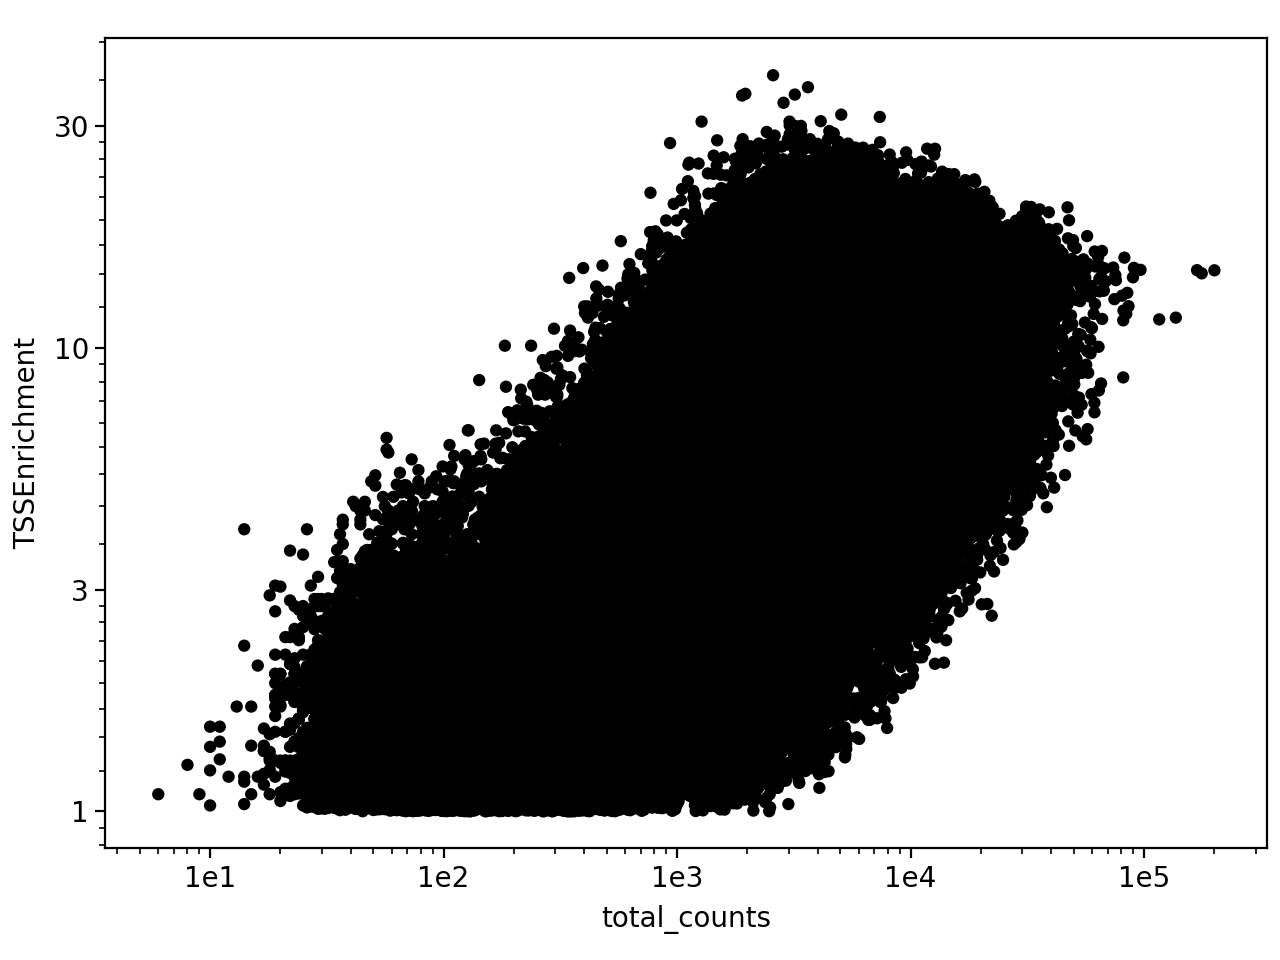

<Figure Size: (640 x 480)>

In [ ]:
ggplot(adata.obs, aes(y="TSSEnrichment", x="total_counts")) + geom_point() + scale_x_log10() + scale_y_log10()

In [ ]:
def quality_control_atac_seq(adata: anndata.AnnData, min_total_counts: int = 500) -> anndata.AnnData:
    """
    Perform quality control on single-nucleus ATAC-seq data by filtering out nuclei based on total read counts.

    Parameters:
    -----------
    adata : anndata.AnnData
        An AnnData object containing single-nucleus ATAC-seq data with observations in rows and genomic regions in columns.

    min_total_counts : int, optional (default=500)
        The minimum number of total reads (counts) required for a nucleus to be considered for further analysis. Nuclei with
        fewer than this number of total counts are removed from the dataset to ensure data quality and reliability.

    Returns:
    --------
    adata : anndata.AnnData
        The filtered AnnData object where nuclei with low total counts have been removed. This dataset is more likely to
        represent biologically relevant and technically reliable data, as it excludes nuclei with potentially poor quality
        sequencing or insufficient chromatin accessibility.
    """
    # Filter nuclei based on the total counts, such that cells with total counts
    # less than min_total_counts are excluded (equivalently, cells with more than min_total_counts are kept)
    adata = adata[adata.obs["total_counts"] >= min_total_counts, :]

    # Save the filtered data to an H5AD file with compression
    adata.write_h5ad("MFC_ATAC_QC.h5ad", compression="gzip")

    # Reload the data from the compressed file in backed mode
    adata = anndata.read_h5ad("MFC_ATAC_QC.h5ad", backed="r")

    return adata

adata = quality_control_atac_seq(adata, min_total_counts=500)

In [ ]:
def refine_atac_seq_data(adata: anndata.AnnData, qc_metrics:List[str]) -> anndata.AnnData:
    """
    Refine ATAC-seq data by removing LSI components strongly correlated with a specified quality control metric and performing batch correction using Harmony.

    Parameters:
    -----------
    adata : anndata.AnnData
        The AnnData object containing single-nucleus ATAC-seq data, which includes LSI components in `obsm['X_lsi']` and batch labels in `obs['library_id']`.

    qc_metric : str
        The name of the quality control metric in `adata.obs` used to assess the correlation with LSI components. High correlation suggests that the component may be driven more by technical variation than biological signal.

    Returns:
    --------
    adata : anndata.AnnData
        The AnnData object with the LSI space refined by removing components highly correlated with the QC metric and integrated over batches using Harmony.

    Notes:
    ------
    - This function does not recompute LSI, but rather filters out components from the existing LSI representation.
    - Batch correction is performed using Harmony, which adjusts the LSI space to minimize batch effects while retaining biological variance.
    """
    bad_indices = set()
    # Check correlation of each LSI component with the specified QC metric
    for met in qc_metrics:
        for i in range(adata.obsm["X_lsi"].shape[1]):
            correlation, _ = pearsonr(adata.obsm["X_lsi"][:, i], adata.obs[met])
            if abs(correlation) > 0.8:  # Threshold for strong correlation
                bad_indices.add(i)

    # Filter out the bad LSI components
    good_indices = [i for i in range(adata.obsm["X_lsi"].shape[1]) if i not in bad_indices]
    adata.obsm["X_lsi"] = adata.obsm["X_lsi"][:, good_indices]

    # Apply Harmony for batch correction
    sc.external.pp.harmony_integrate(adata, key="library_id", basis="X_lsi", adjusted_basis="X_lsi_harmony")

    # Update the neighborhood graph using the harmonized LSI components
    sc.pp.neighbors(adata, use_rep="X_lsi_harmony")

    # Compute UMAP and leiden
    sc.tl.umap(adata)
    sc.tl.leiden(adata)
    return adata

# Example of usage
adata = refine_atac_seq_data(adata, qc_metric='total_counts')

## 4.2

ATAC-seq Data Structure and Peaks: ATAC-seq provides a snapshot of chromatin accessibility across the genome. The technique identifies regions where the chromatin is "open" and thus accessible to transcription factors and other regulatory proteins. These open regions are detected as "peaks" in the ATAC-seq data. Each peak corresponds to a specific start and end point on the genome where the chromatin is less condensed, indicating potential regulatory activity.


In [ ]:
def analyze_differential_accessibility(adata: anndata.AnnData, groupby: str):
    """
    Analyze differentially accessible genomic peaks in microglia from ATAC-seq data using PyDESeq2 and visualize the results in a volcano plot.

    Parameters:
    -----------
    adata : anndata.AnnData
        The input AnnData object containing ATAC-seq data. This data should include 'peak' data in `.var` and the accessibility matrix in `.X`.
        Additionally, `adata.obs` must contain a column specifying the sample or condition grouping and a column identifying microglia cells.

    groupby : str
        The name of the column in `adata.obs` to be used for grouping the data in the differential accessibility analysis. This typically will be a
        condition label such as 'disease_status' that differentiates between experimental groups (e.g., 'control' vs 'Alzheimer's').

    Returns:
    --------
    None
        This function does not return a value but generates a volcano plot as output. The plot displays log2 fold changes on the x-axis against
        -log10 p-values on the y-axis, with points colored by chromosome to highlight chromosomal patterns of accessibility differences.

    Notes:
    ------
    - The function filters for microglia cells before proceeding with the analysis. Ensure that `adata.obs` includes an appropriate identifier for cell types.
    - Differential accessibility analysis is performed using PyDESeq2, which requires count data and group labels.
    - The volcano plot is helpful for visualizing statistically significant peaks with considerable changes in accessibility between groups.
    - Points in the volcano plot are colored based on their chromosome, which must be included in the `adata.var` metadata.

    Example:
    --------
    >>> adata = anndata.read_h5ad("path_to_adata_file.h5ad")
    >>> analyze_differential_accessibility(adata, groupby='disease_status')
    """
    # Example pseudocode for the function body:
    # Filter the data to include only microglia cells
    # Use your code from (2)
    ps_mic = pseudobulk(adata[adata.obs["CellType"] == "Mic", :])
    sc.pp.calculate_qc_metrics(ps_mic, inplace=True)

    # Perform differential accessibility analysis using PyDESeq2
    # This would involve setting up a DESeq2 dataset, running the analysis, and retrieving results
    run_deseq2(ps_mic)
    # Generate a volcano plot from the results
    # Plotting functions would use log2 fold changes and -log10 p-values, coloring by chromosome
    pass

## 4.3 ATAC-Seq per-cell score

In [ ]:
def atac_seq_score_mic(adata:anndata.AnnData, deg_df:pd.DataFrame, rna_df:pd.DataFrame):
    """Just like with snRNA-seq, you can log normalize the peaks to compute the score. Then,
    compare the RNA-based score with the ATAC-based score on cells that have both.
    Pass the rna .obs dataframe to rna_df.
    """
    add_deg_score(adata) ### What are the correct parameters here?
    ###

Does the RNA-seq based score in microglia correspond to the ATAC-seq based score in microglia given the differential set?

---

##### Student Explanation Here: **Write your response here and delete this comment**

---

## 4.4 Motif counting

Given the DNA sequence for each peak, complete the motif scoring function and compute how many motifs are in each peak.

In [ ]:
def compute_score_cutoff(motif:Bio.motifs.jaspar.Motif, precision:int=10000, pvalue=0.001):
  """Generates `precision` random DNA sequences under the distribution motif.background, then picks the top 99.9% score if pvalue=0.001.
  """
  pwm = motif.pwm
  pass

def score_motifs_sequences(motif:Bio.motifs.jaspar.Motif, sequences:List[str], pvalue=1e-3) -> np.ndarray:
  """For a Motif, compute the PWM score. Don't forget the reverse_complement() PWM scoring as well.
  You can use .pssm.search here, assuming you didn't use it for compute_score_cutoff.
  Return a list of integers representing the number of matches per sequence.
  """
  pwm = motif.pwm
  score_threshold = compute_score_cutoff(motif, pvalue=pvalue)
  pass

adata.varm["motif_match"] = np.zeros((adata.shape[1], len(MOTIF_LIST)), dtype=np.int16)
adata.uns['motif_name'] = [None] * len(MOTIF_LIST)
for i, motif in enumerate(MOTIF_LIST):
  counts = score_motifs_sequences(motif, adata.uns["peak_seq"])
  adata.varm["motif_match"][:, i] = counts
  adata.uns['motif_name'][i] = motif.matrix_id + "." + motif.name

## 4.5 Compute motif binding site per-cell scores

From the motif matches, compute [chromVar](https://www.nature.com/articles/nmeth.4401) scores by completing the function below.

For three JASPAR transcription factors you found in the genome, plot the ChromVar deviation score on a violin plot per cell type.

It may be helpful to look at source code online of chromVar or pychromVar.

In [ ]:
def compute_chromvar(adata:anndata.AnnData, motif_name:str, batch_size:int=5000):
  """For some motif `motif_name`, compute the ChromVar score, that is,
  compute for every cell the (observed - expected)/expected motif counts.
  Then compute on background peaks this score, and standardize the real score using the distribution
  of background scores --- that is, subtract the mean background score and divide by the standard deviation of background scores"""
  idx = adata.uns['motif_name'].index(motif_name)
  matches = adata.varm["motif_match"][:, idx]
  exp_var = adata.var["total_counts"].values[None, :] / adata.var["total_counts"].sum()
  exp_obs = adata.obs["total_counts"].values[:, None]
  for X, start, end in tqdm(adata.chunked_X(batch_size)):
    observed = X.dot(matches)
    expected = exp_obs[start:end] @ (exp_var @ matches)
    out = np.zeros_like(expected).astype(np.float32)
    np.divide(observed - expected, expected, where=expected != 0, out=out)
    ### To fill in: background peaks using indices from adata.varm[bg_peaks][:, j] for j in range(50)
  adata.obs[motif_name] = None ### To fill in: (real - np.mean(background))/np.std(background)
